# 1 assemble the system

In [1]:
from scipy.optimize import curve_fit
import scipy
from scipy.special import erfc
from skimage.transform import radon
from CoupledQuantumSystems.qobj_manip import find_dominant_frequency,get_product_vectorized,dressed_to_product_vectorized
from CoupledQuantumSystems.systems import FluxoniumOscillatorSystem
import numpy as np
from CoupledQuantumSystems.mcsolve_utils import *
from CoupledQuantumSystems.drive import DriveTerm, square_pulse_with_rise_fall
from CoupledQuantumSystems.mcsolve_utils import pack_mcsolve_chunks, pack_pkl_files_to_zip, merge_results
import matplotlib.pyplot as plt
import qutip

In [2]:
max_ql = 25
max_ol = 200
EJ = 4
EC = EJ/2.0
EL = EJ/30
Er = 13.63285461

g = 0.3
w_d = 13.6355
amp = 0.01
kappa = 2e-3

tot_time =500
tlist = np.linspace(0, tot_time, tot_time)


with open('../gf_new/gf_mcsolve_system_g3a01k002.pkl', 'rb') as f:
    system = pickle.load(f)

# 2 store the mcsolve jobs

In [3]:
state_leak_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(1,0)])
state_0_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(0,0)])
state_1_dressed = qutip.basis(max_ql * max_ol, system.product_to_dressed[(2,0)])
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                    state_leak_dressed,
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

leakage_products_to_keep = [[ql, ol] for ql in [1] for ol in range(max_ol) ]
computational_products_to_keep = [[ql, ol] for ql in [0,1,2] for ol in range(70) ]
list_of_products_to_keep = [
    leakage_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep,
    computational_products_to_keep
]

ntraj_per_y0 = 1000
chunk_size = 4
existing_chunk_num = 0
for y0, products_to_keep in zip(initial_states, list_of_products_to_keep):
    system.set_new_product_to_keep(products_to_keep)
    system.set_new_operators_after_setting_new_product_to_keep()
    existing_chunk_num = pack_mcsolve_chunks(
                    y0 = system.truncate_function(y0),
                    tlist = tlist,
                    static_hamiltonian = system.diag_dressed_hamiltonian,
                    drive_terms = [DriveTerm( 
                                driven_op= system.driven_operator,
                                pulse_shape_func=square_pulse_with_rise_fall,
                                pulse_shape_args={
                                    'w_d': w_d ,
                                    'amp': amp,
                                    't_rise': 20,
                                    't_square': tot_time
                                })],                    
                    c_ops = system.c_ops,
                    e_ops = [system.a_trunc , system.a_trunc.dag()*system.a_trunc],
                    ntraj = ntraj_per_y0,
                    existing_chunk_num = existing_chunk_num,
                    chunk_size = chunk_size)
    
pack_pkl_files_to_zip(zip_filename="mcsolve_input_gf_3_lvl.zip")

# 3 sent to condor and run


# 4 load the mcsolve results, average them

In [4]:
zip_files = [f"zipped_results/result_{i}.zip" for i in range(1750)]
n_parts = len(initial_states)
part_length = len(zip_files) // n_parts
zip_file_parts = [zip_files[i * part_length : (i + 1) * part_length] for i in range(n_parts)]

results = []
for part in zip_file_parts:
    results.append(merge_results(part))

with open('averaged.pkl', 'wb') as f:
    pickle.dump(results,f)

progress: 100%|██████████| 250/250 [01:49<00:00,  2.28it/s]


In [5]:
# with open('averaged.pkl', 'rb') as f:
#     results = pickle.load(f)

In [5]:
for i, (result, products_to_keep) in enumerate(zip(results, list_of_products_to_keep)):
    # result.states_in_product_basis = system.convert_dressed_to_product_vectorized(result.states,
    #                                                                                 products_to_keep,
    #                                                                                 )
    states = result.states
    process_chunk_size = 25
    num_chunks = len(states) // process_chunk_size + (len(states) % process_chunk_size != 0)

    processed_states = []
    for i in range(num_chunks):
        start_idx = i * process_chunk_size
        end_idx = min((i + 1) * process_chunk_size, len(states))
        print(f"{start_idx, end_idx}")
        chunk = states[start_idx:end_idx]
        processed_chunk = system.convert_dressed_to_product_vectorized(chunk,products_to_keep)
        processed_states.extend(processed_chunk)
        print(len(processed_states))
    result.states_in_product_basis = processed_states
    print(f"done one")
with open('mcsolve_results_with_product_basis.pkl', 'wb') as f:
    pickle.dump(results,f)

(0, 25)
25
(25, 50)
50
(50, 75)
75
(75, 100)
100
(100, 125)
125
(125, 150)
150
(150, 175)
175
(175, 200)
200
(200, 225)
225
(225, 250)
250
(250, 275)
275
(275, 300)
300
(300, 325)
325
(325, 350)
350
(350, 375)
375
(375, 400)
400
(400, 425)
425
(425, 450)
450
(450, 475)
475
(475, 500)
500
done one
(0, 25)
25
(25, 50)
50
(50, 75)
75
(75, 100)
100
(100, 125)
125
(125, 150)
150
(150, 175)
175
(175, 200)
200
(200, 225)
225
(225, 250)
250
(250, 275)
275
(275, 300)
300
(300, 325)
325
(325, 350)
350
(350, 375)
375
(375, 400)
400
(400, 425)
425
(425, 450)
450
(450, 475)
475
(475, 500)
500
done one
(0, 25)
25
(25, 50)
50
(50, 75)
75
(75, 100)
100
(100, 125)
125
(125, 150)
150
(150, 175)
175
(175, 200)
200
(200, 225)
225
(225, 250)
250
(250, 275)
275
(275, 300)
300
(300, 325)
325
(325, 350)
350
(350, 375)
375
(375, 400)
400
(400, 425)
425
(425, 450)
450
(450, 475)
475
(475, 500)
500
done one
(0, 25)
25
(25, 50)
50
(50, 75)
75
(75, 100)
100
(100, 125)
125
(125, 150)
150
(150, 175)
175
(175, 200)
2

In [5]:
with open('mcsolve_results_with_product_basis.pkl', 'rb') as f:
    results = pickle.load(f)

In [6]:
last_t_idx = 449
t_indices = [0, 90, 180, 270, 360, 449]

# calculate leakage

In [7]:

leakage_arr = np.zeros(shape=(3,len(tlist)))
for ql,result in zip([0,1,2],[results[1],results[0],results[2]]):
    initial_qbt_state = qutip.basis(max_ql,  ql)
    op = initial_qbt_state * initial_qbt_state.dag()
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = result.states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[ql,t_idx] = 1-qutip.expect(op, rho_qbt)

t loop: 100%|██████████| 500/500 [00:01<00:00, 388.14it/s]


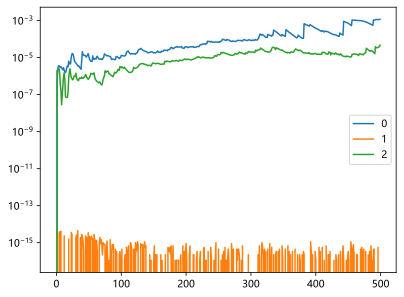

In [8]:
for ql in [0,1,2]:
    plt.plot(leakage_arr[ql],label=f'{ql}')
plt.legend()
plt.yscale('log')

In [34]:
leakage_arr = np.zeros(shape=(max_ql,len(tlist)))
ql = 0
result= results[1]
for i in range(max_ql):
    initial_qbt_state = qutip.basis(max_ql,  i)
    op = initial_qbt_state * initial_qbt_state.dag()
    for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
        rho_product = result.states_in_product_basis[t_idx]
        rho_qbt = qutip.Qobj(np.array(rho_product.ptrace(0)))
        leakage_arr[i,t_idx] = qutip.expect(op, rho_qbt)

t loop: 100%|██████████| 500/500 [00:02<00:00, 204.81it/s]


In [35]:
all_zeros = not np.any(leakage_arr[1:,:])
all_zeros 

False

# TODO: find dressed matrix element

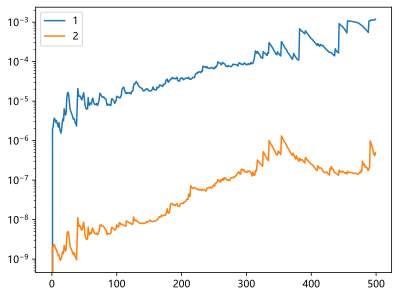

In [37]:
for i in range(1,3):
    plt.plot(leakage_arr[i],label=f'{i}')
plt.legend()
plt.yscale('log')

In [ ]:
bitflip_arr = np.zeros(shape=(2,len(tlist)))

qbt_0 = qutip.basis(max_ql,  0)
op_0 = qbt_0 * qbt_0.dag()
qbt_2 = qutip.basis(max_ql,  2)
op_2 = qbt_2 * qbt_2.dag()

result = results[1]
for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
    rho_qbt = qutip.Qobj(np.array(result.states_in_product_basis[t_idx].ptrace(0)))
    bitflip_arr[0,t_idx] = qutip.expect(op_2, rho_qbt) / (qutip.expect(op_2, rho_qbt) + qutip.expect(op_0, rho_qbt))

result = results[2]
for t_idx in tqdm(range(len(tlist)), desc = "t loop"):
    rho_qbt = qutip.Qobj(np.array(result.states_in_product_basis[t_idx].ptrace(0)))
    bitflip_arr[1,t_idx] = qutip.expect(op_0, rho_qbt) / (qutip.expect(op_2, rho_qbt) + qutip.expect(op_0, rho_qbt))

# Plotting

# computational states

In [9]:
def truncate_to_computational(state,i,j):
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

def calc_average_fidelity_with_phase(phase,dms,states_ideal):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


Processing: 100%|██████████| 500/500 [00:52<00:00,  9.52it/s]


Text(0.5, 1.0, 'infidelity')

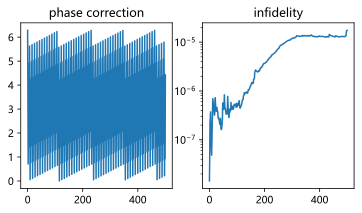

In [10]:
from scipy.optimize import minimize
infidelity = []
phase = []
original_phase = 2*np.pi*tlist*(system.evals[system.product_to_dressed[(2,0)]]-system.evals[system.product_to_dressed[(0,0)]]) + np.pi
original_phase = original_phase % (2*np.pi) 

for idx in tqdm(range(len(tlist)), desc='Processing'):
    dms = [truncate_to_computational(result.states_in_product_basis[idx].ptrace(0), 0,2) for result in results[1:]]
    def objective_function(phase):
        return calc_average_fidelity_with_phase(phase[0], dms, states_ideal)
    opt_result = minimize(objective_function,x0=  [original_phase[idx]],bounds = [(0, 2*np.pi)], method="Powell")
    infidelity.append(opt_result.fun)
    phase.append(opt_result.x[0])
    

fig, axes = plt.subplots(1,2,figsize = (6,3))
axes[0].plot(tlist,phase)
axes[0].set_title('phase correction')
axes[1].plot(tlist,infidelity)
axes[1].set_yscale('log')
axes[1].set_title('infidelity')
